In [35]:
import torch
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.utils.parametrize as parametrize
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MulticlassConfusionMatrix

from transformers import AutoModel, AutoTokenizer

from src.train_func import train, test
from src.loRA import LoRAParametrization, lora_parameterization, enable_disable_lora

In [2]:
import warnings; warnings.filterwarnings("ignore")
torch.set_printoptions(precision=3, linewidth=125, sci_mode=False)
_=torch.manual_seed(0)

In [3]:
RANK = 4
MODEL_NAME = "huawei-noah/TinyBERT_General_4L_312D"
DATA_PATH = "../data/finnews.csv"
TRND_BERT_PTH = "../models/whtout-lora-trainedbert.pth"
TRND_BERTLORA_PTH =  "../models/wht-lora-trainedbert.pth"

In [4]:
finbert = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
total_parameter_original = sum([p.numel() for p in finbert.parameters()])

In [5]:
total_parameter_original

14350248

In [68]:
data = pd.read_csv(DATA_PATH)
encoders = {'neutral':0, 'positive':1, 'negative':2}
label_encoders = {k:i for i,k in encoders.items()}
data['sentiment'] = data['sentiment'].map(encoders)

In [7]:
class FinBERTSentimentClassifier(torch.nn.Module):
    def __init__(self, finbert):
        super(FinBERTSentimentClassifier, self).__init__()
        self.finbert = finbert
        self.classifier = torch.nn.Linear(self.finbert.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask):
        # Get the pooled output from FinBERT
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        pooler_output = outputs.pooler_output  # Shape: (batch_size, hidden_size)
        logits = self.classifier(pooler_output)
        return logits

model = FinBERTSentimentClassifier(finbert)
model.load_state_dict(torch.load(TRND_BERT_PTH))

<All keys matched successfully>

In [8]:
for name, params in model.named_parameters():
    module = dict(model.named_modules()).get(name.rsplit('.', 1)[0])
    if isinstance(module, (nn.Linear, nn.Embedding)):
        print(f"{name}: {params.shape}")

finbert.embeddings.word_embeddings.weight: torch.Size([30522, 312])
finbert.embeddings.position_embeddings.weight: torch.Size([512, 312])
finbert.embeddings.token_type_embeddings.weight: torch.Size([2, 312])
finbert.encoder.layer.0.attention.self.query.weight: torch.Size([312, 312])
finbert.encoder.layer.0.attention.self.query.bias: torch.Size([312])
finbert.encoder.layer.0.attention.self.key.weight: torch.Size([312, 312])
finbert.encoder.layer.0.attention.self.key.bias: torch.Size([312])
finbert.encoder.layer.0.attention.self.value.weight: torch.Size([312, 312])
finbert.encoder.layer.0.attention.self.value.bias: torch.Size([312])
finbert.encoder.layer.0.attention.output.dense.weight: torch.Size([312, 312])
finbert.encoder.layer.0.attention.output.dense.bias: torch.Size([312])
finbert.encoder.layer.0.intermediate.dense.weight: torch.Size([1200, 312])
finbert.encoder.layer.0.intermediate.dense.bias: torch.Size([1200])
finbert.encoder.layer.0.output.dense.weight: torch.Size([312, 1200])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def apply_lora(model, layers, rank=1):
    for name, module in model.named_modules():
        if isinstance(module, layers):
            parametrize.register_parametrization(
                module, "weight", lora_parameterization(module, device, rank=rank)
            )

apply_lora(model=model, layers=(nn.Linear, nn.Embedding), rank=RANK)

In [10]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for name, layer in model.named_modules():
    if isinstance(layer, nn.Linear):
        total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
        total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
        print(
            f'W: {layer.weight.shape} + B: {layer.bias.shape} Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
        )
    if isinstance(layer, nn.Embedding):
        total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
        total_parameters_non_lora += layer.weight.nelement()
        print(
            f'W: {layer.weight.shape}  Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
        )
    # else:
    #     total_parameters_non_lora += layer.weight.nelement()

# assert total_parameters_non_lora == total_parameter_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

W: torch.Size([30522, 312])  Lora_A: torch.Size([4, 312]) + Lora_B: torch.Size([30522, 4])
W: torch.Size([512, 312])  Lora_A: torch.Size([4, 312]) + Lora_B: torch.Size([512, 4])
W: torch.Size([2, 312])  Lora_A: torch.Size([4, 312]) + Lora_B: torch.Size([2, 4])
W: torch.Size([312, 312]) + B: torch.Size([312]) Lora_A: torch.Size([4, 312]) + Lora_B: torch.Size([312, 4])
W: torch.Size([312, 312]) + B: torch.Size([312]) Lora_A: torch.Size([4, 312]) + Lora_B: torch.Size([312, 4])
W: torch.Size([312, 312]) + B: torch.Size([312]) Lora_A: torch.Size([4, 312]) + Lora_B: torch.Size([312, 4])
W: torch.Size([312, 312]) + B: torch.Size([312]) Lora_A: torch.Size([4, 312]) + Lora_B: torch.Size([312, 4])
W: torch.Size([1200, 312]) + B: torch.Size([1200]) Lora_A: torch.Size([4, 312]) + Lora_B: torch.Size([1200, 4])
W: torch.Size([312, 1200]) + B: torch.Size([312]) Lora_A: torch.Size([4, 1200]) + Lora_B: torch.Size([312, 4])
W: torch.Size([312, 312]) + B: torch.Size([312]) Lora_A: torch.Size([4, 312]) + 

In [ ]:
def freeze_params(model):
    for name, param in model.named_parameters():
        # Check if 'lora' is not in the parameter name and it is not the classifier layer
        if 'lora' not in name and 'classifier' not in name and 'fc' not in name:  # Add any keywords identifying the classifier
            print(f'Freezing non-LoRA parameter {name}')
            param.requires_grad = False

freeze_params(model=model)

In [12]:
def check_frozen_parameters(model):
    frozen_params = []
    trainable_params = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params.append(param)
        else:
            frozen_params.append(param)

    print(f"Frozen Parameters: {sum([p.nelement() for p in frozen_params])}")
    print(f"Trainable Parameters: {sum([p.nelement() for p in trainable_params])}")
    
check_frozen_parameters(model)

Frozen Parameters: 14350248
Trainable Parameters: 220903


In [13]:
class FinData(torch.utils.data.Dataset):
    def __init__(self, x, y, tokenizer, device='cpu'):self.x,self.y,self.tokenizer,self.device = x,y,tokenizer,device
    def __len__(self):return len(self.x)
    def __getitem__(self, idx):
        inputs = self.tokenizer(self.x[idx], return_tensors="pt", padding="max_length", truncation=True, max_length=256)
        input_ids = inputs["input_ids"].squeeze().to(self.device)
        attention_mask = inputs["attention_mask"].squeeze().to(self.device)
        label = torch.tensor(self.y[idx], dtype=torch.long).to(self.device)
        return {"input_ids": input_ids, "attention_mask": attention_mask}, label

In [14]:
class GET_DLS:
    def __init__(self, data, tsz, random_state):self.data, self.tsz, self.random_state = data, tsz, random_state
    def get_dls(self, batch_size):
        # split training and testing data
        X_train, X_test, y_train, y_test = train_test_split(self.data['news'], self.data['sentiment'], test_size=self.tsz, random_state=self.random_state)
        X_train, X_test, y_train, y_test = [df.reset_index(drop=True) for df in (X_train, X_test, y_train, y_test)]
        
        # make train dataset and dataloader
        train_dataset = FinData(X_train, y_train, tokenizer)
        train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # make test dataset and dataloader
        test_dataset = FinData(X_test, y_test, tokenizer)
        test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size*2, shuffle=True)
        
        return train_dl, test_dl

In [ ]:
# model.load_state_dict(torch.load(TRND_BERTLORA_PTH))

<All keys matched successfully>

In [16]:
TSZ = 0.33
RANDOM_STATE = 42
BATCH_SIZE = 8
EPOCHS = 1
LR = 0.001

In [17]:
train_dl, test_dl = GET_DLS(data, tsz=TSZ, random_state=RANDOM_STATE).get_dls(BATCH_SIZE)

In [18]:
train(
    train_loader=train_dl,
    test_dl=test_dl,
    net=model,
    epochs=EPOCHS,
    total_iterations_limit=None,
    device="cpu",
    lr=LR
)

Testing: 100%|██████████| 305/305 [05:08<00:00,  1.01s/it]

Epoch 1: train loss: 0.066, val loss: 0.256, train acc: 0.980, val acc: 0.947


In [25]:
torch.save(model.state_dict(), "../models/wht-lora-trainedbert.pth")

In [ ]:
from tqdm import tqdm
def get_predictions(model, dl, device):
    model.eval()
    predictions,targets = [],[]
    with torch.no_grad():
        for data, labels in tqdm(dl, desc="Predicting"):
            input_ids = data['input_ids'].to(device)
            attn_masks = data['attention_mask'].to(device)
            labels = labels.to(device)

            logits = model(input_ids, attn_masks)
            outputs = F.softmax(logits, dim=-1)
            pred = torch.argmax(outputs, dim=-1)

            predictions.extend(labels.cpu().detach())
            targets.extend(pred.cpu().detach())
    return predictions, targets

In [22]:
predictions, targets = get_predictions(model, test_dl, device=device)

Predictiong: 100%|██████████| 305/305 [06:35<00:00,  1.30s/it]


In [33]:
def plt_cmf(preds, targs, nmc, save:str=None):
    mcm = MulticlassConfusionMatrix(num_classes=3)
    preds = torch.tensor(preds)
    targs = torch.tensor(targs)
    cmf = mcm(preds, targs)
    sns.heatmap(cmf, annot=True, fmt='g', cmap='coolwarm', linewidths=0.5)
    if save is not None:plt.savefig(save)
    plt.show()

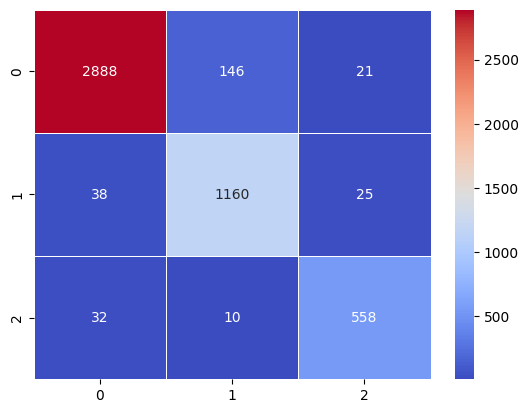

In [34]:
plt_cmf(predictions, targets, nmc=3, save="../figures/confusion-mtx.png")

In [66]:
def predict_sentiments(model, dl, n, label_encoders):
    texts, real_sentiments, predicted_sentiments = [], [], []

    for data, labels in dl:
        random_indices = torch.randint(0, data['input_ids'].size(0), (n,))
        random_input_ids = data['input_ids'][random_indices]
        random_attention_mask = data['attention_mask'][random_indices]
        random_labels = labels[random_indices]

        logits = model(random_input_ids, random_attention_mask)
        preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1)

        texts = [tokenizer.decode(ids.cpu(), skip_special_tokens=True) for ids in random_input_ids]
        real_sentiments = [label_encoders[label.item()] for label in random_labels]
        predicted_sentiments = [label_encoders[pred.item()] for pred in preds]
        break  

    for i, (text, real, pred) in enumerate(zip(texts, real_sentiments, predicted_sentiments), 1):
        print(f"Text {i}: {text}")
        print(f"  Real Sentiment: {real}")
        print(f"  Predicted Sentiment: {pred}")
        print("-" * 50)

    return texts, real_sentiments, predicted_sentiments


In [67]:
predict_sentiments(model, test_dl, n=5, label_encoders=label_encoders)

Text 1: the purchase price was not disclosed.
  Real Sentiment: neutral
  Predicted Sentiment: neutral
--------------------------------------------------
Text 2: these moderate but significant changes resulted in a significant 24 - 32 % reduction in the estimated cvd risk.
  Real Sentiment: positive
  Predicted Sentiment: positive
--------------------------------------------------
Text 3: operating profit rose to eur2. 4 m from eur1. 6 m year earlier.
  Real Sentiment: positive
  Predicted Sentiment: positive
--------------------------------------------------
Text 4: pre - tax loss totaled eur 0. 3 mn, compared to a loss of eur 2. 2 mn in the first quarter of 2005.
  Real Sentiment: positive
  Predicted Sentiment: positive
--------------------------------------------------
Text 5: we aim to ensure that vacon is in good shape when capital expenditure starts to pick up again,'' comments vacon plc president and ceo vesa laisi.
  Real Sentiment: positive
  Predicted Sentiment: positive
---

(['the purchase price was not disclosed.',
  'these moderate but significant changes resulted in a significant 24 - 32 % reduction in the estimated cvd risk.',
  'operating profit rose to eur2. 4 m from eur1. 6 m year earlier.',
  'pre - tax loss totaled eur 0. 3 mn, compared to a loss of eur 2. 2 mn in the first quarter of 2005.',
  "we aim to ensure that vacon is in good shape when capital expenditure starts to pick up again,'' comments vacon plc president and ceo vesa laisi."],
 ['neutral', 'positive', 'positive', 'positive', 'positive'],
 ['neutral', 'positive', 'positive', 'positive', 'positive'])

#### Export